# Duckietown NCTU - Tutorial 7: RANSAC + ICP

By Nick Wang

## Import Packages

In [1]:
import numpy as np
import scipy as sp
import cv2
import time
from matplotlib import pyplot as plt

from skimage.measure import LineModelND, ransac

%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

/home/robotvision/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## RANSAC Examples

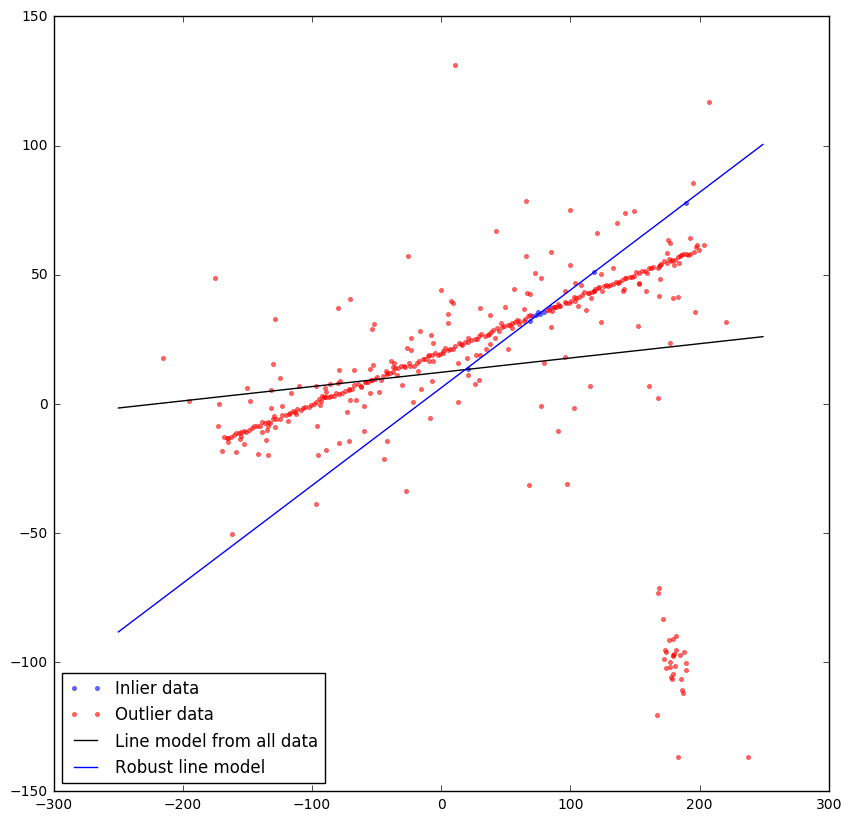

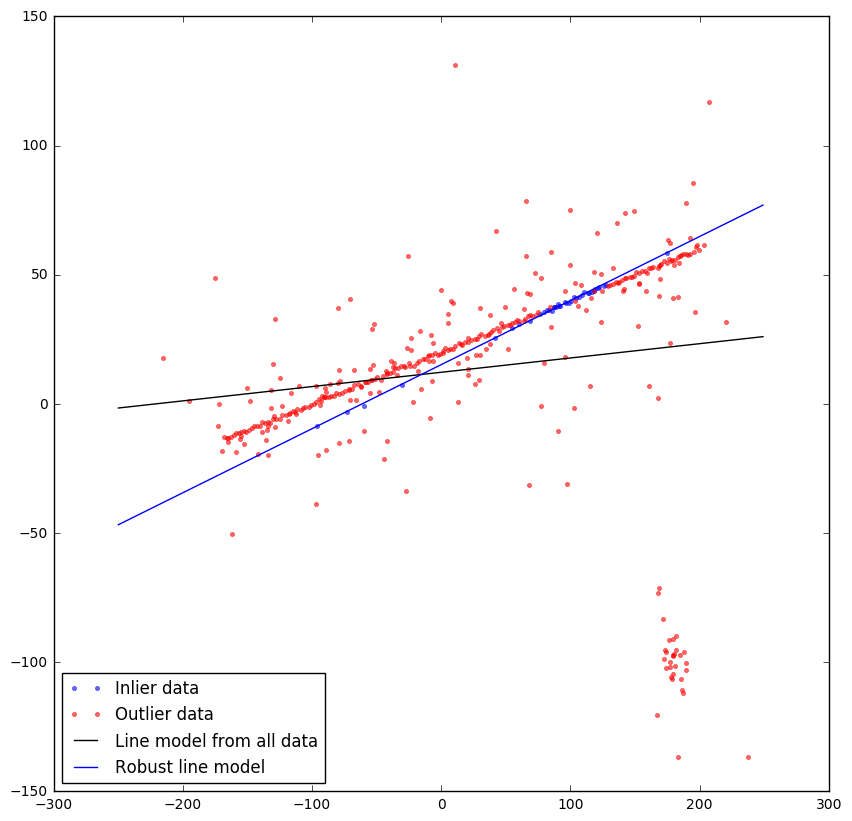

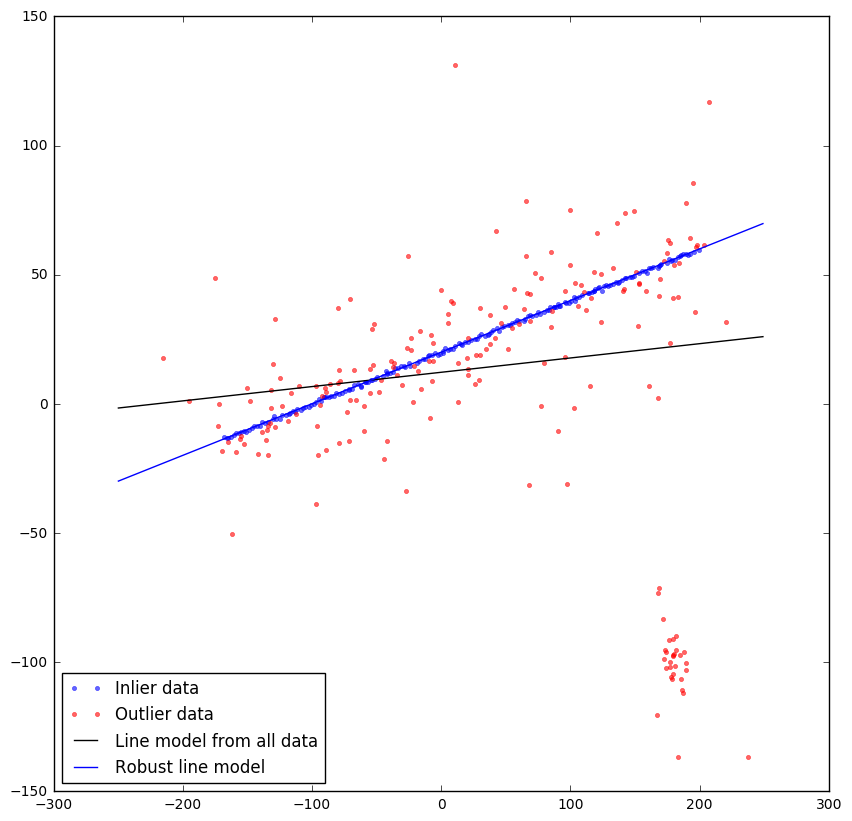

In [3]:

np.random.seed(seed=1)

# generate coordinates of line
x = np.arange(-200, 200)
y = 0.2 * x + 20
data = np.column_stack([x, y])

# add faulty data
faulty = np.array(30 * [(180., -100)])
faulty += 5 * np.random.normal(size=faulty.shape)
data[:faulty.shape[0]] = faulty

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape)
data += 0.5 * noise
data[::2] += 5 * noise[::2]
data[::4] += 20 * noise[::4]

# fit line using all data
model = LineModelND()
model.estimate(data)

for i in [1, 5, 10]:
    
    # robustly fit line only using inlier data with RANSAC algorithm
    model_robust, inliers = ransac(data, LineModelND, min_samples=2, residual_threshold=1, max_trials=i)
    outliers = inliers == False

    # generate coordinates of estimated models
    line_x = np.arange(-250, 250)
    line_y = model.predict_y(line_x)
    line_y_robust = model_robust.predict_y(line_x)

    fig, ax = plt.subplots()
    ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6,
            label='Inlier data')
    ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha=0.6,
            label='Outlier data')
    ax.plot(line_x, line_y, '-k', label='Line model from all data')
    ax.plot(line_x, line_y_robust, '-b', label='Robust line model')
    ax.legend(loc='lower left')
    plt.show()
    

## ICP Exercise

In this exercise you will use a standard ICP algorithm with the point-to-point distance metric to estimate the transform between the 2D datasets (model - red and target - green) depicted in the below figure. For the correspondence estimation please use the nearest neighbor search with the maximum radius set to 4 grid units.

[0, 18, 0, 18]

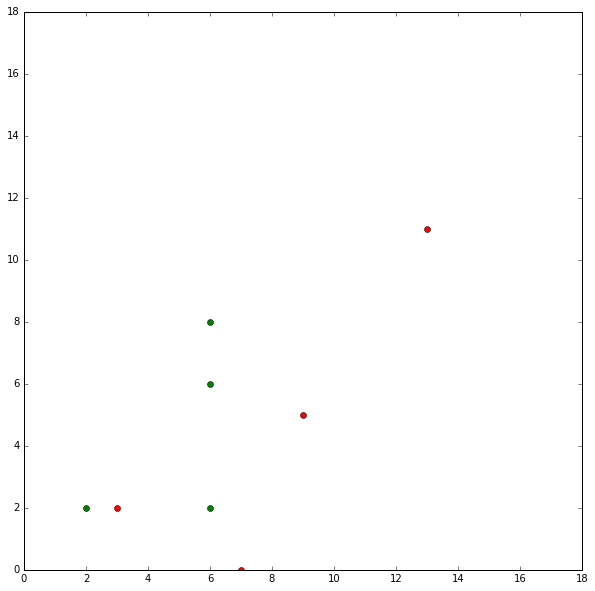

In [17]:
plt.plot([3,7,9,13], [2,0,5,11], 'ro')
plt.plot([2,6,6,6], [2,2,6,8], 'go')
plt.axis([0, 18, 0, 18])

### 1. Find Point Pairs. You should be careful about the NN search radius, and reject outlier.

In [4]:
p_1t = np.array([2, 2], dtype='f')
p_2t = np.array([6, 2], dtype='f')
p_3t = np.array([6, 6], dtype='f')
p_ct = (p_1t + p_2t + p_3t)/3
print p_ct

p_1m = np.array([3, 2], dtype='f')
p_2m = np.array([7, 0], dtype='f')
p_3m = np.array([9, 5], dtype='f')
p_cm = (p_1m + p_2m + p_3m)/3
print p_cm

[ 4.66666651  3.33333325]
[ 6.33333349  2.33333325]


### 2. Compute Centroids

In [5]:
p_1t = np.array([2, 2], dtype='f')
p_2t = np.array([6, 2], dtype='f')
p_3t = np.array([6, 6], dtype='f')
p_ct = (p_1t + p_2t + p_3t)/3
print p_ct

p_1m = np.array([3, 2], dtype='f')
p_2m = np.array([7, 0], dtype='f')
p_3m = np.array([9, 5], dtype='f')
p_cm = (p_1m + p_2m + p_3m)/3
print p_cm

[ 4.66666651  3.33333325]
[ 6.33333349  2.33333325]


### 3. Build the Correlation Matrix H

In [37]:
p_1td = p_1t - p_ct
p_2td = p_2t - p_ct
p_3td = p_3t - p_ct
# print p_1td,p_2td,p_3td

p_1tm = p_1m - p_cm
p_2tm = p_2m - p_cm
p_3tm = p_3m - p_cm
# print p_1tm,p_2tm,p_3tm

Mtd = np.vstack((p_1td, p_2td, p_3td)).transpose()
# print Mtd
Mmd = np.vstack((p_1tm, p_2tm, p_3tm)).transpose()
# print Mmd

H = np.dot(Mmd, Mtd.transpose())
print H

[[ 13.33333206  10.66666603]
 [  1.33333325  10.66666698]]


### 4. Estimate Rotation Matrix R using SVD

In [58]:
[U, D, V] = np.linalg.svd(H,full_matrices=1)
R = np.dot(V,U.transpose())
print R

[[ 0.93200469 -0.36244628]
 [ 0.36244628  0.93200469]]


### 5. Estimate the translation vector t

In [80]:
t = np.matrix(p_ct - np.dot(R,p_cm))
print t

[[-0.39032221 -1.13683772]]


### 6. Calculate the transform T

In [96]:
# print R.shape
# print t.transpose()

temp = np.hstack((R,t.transpose()))
zero = np.array([[0,0,1]])
T = np.vstack((temp,zero))

print T

[[ 0.93200469 -0.36244628 -0.39032221]
 [ 0.36244628  0.93200469 -1.13683772]
 [ 0.          0.          1.        ]]


### 7. Transform Dataset m using the transform T

In [141]:
p1_m = np.append([np.matrix(p_1m)],[1])
p2_m = np.append([np.matrix(p_2m)],[1])
p3_m = np.append([np.matrix(p_3m)],[1])

t1 = np.dot(T,p1_m.transpose())[0,0:2]
t2 = np.dot(T,p2_m.transpose())[0,0:2]
t3 = np.dot(T,p3_m.transpose())[0,0:2]
print t1
print t2
print t3

[[ 1.68079931  1.81451049]]
[[ 6.13371062  1.40028623]]
[[ 6.18548861  6.78520223]]


[0, 18, 0, 18]

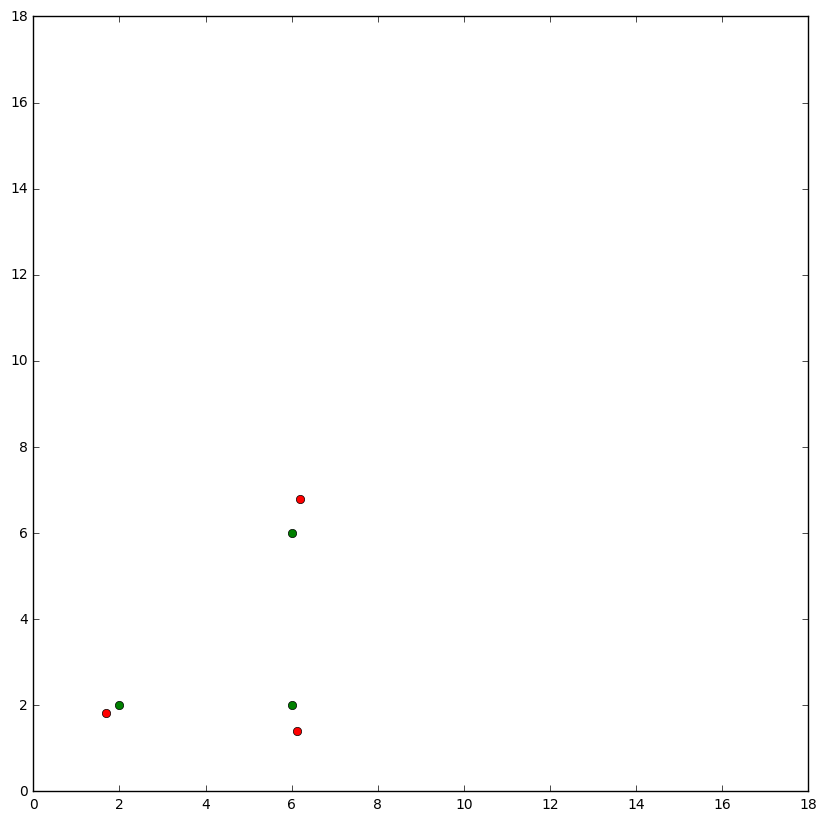

In [152]:
t_x = np.append([t1[0,0]],[t2[0,0],t3[0,0]])
t_y = np.append([t1[0,1]],[t2[0,1],t3[0,1]])
# print t_x
# print t_y
plt.plot(t_x,t_y, 'ro')
plt.plot([2,6,6], [2,2,6], 'go')
plt.axis([0, 18, 0, 18])